In this notebook, we do data imputation with MICE (Multiple Imputation with Chained Equations)

# 1. Load data & declare variables

In [8]:
# !pip install impyute

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from impyute.imputation.cs import mice
import xgboost as xgb
import miceforest as mf
from sklearn.metrics import roc_curve, confusion_matrix, auc, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score
from tensorflow import keras
from tensorflow.keras import layers
from fancyimpute import KNN

In [12]:
df = pd.read_csv('../database/2016-2022.csv')

In [13]:
binary = ['unequal_voting','classified_board_system','poison_pill','operating_margin_below_3y_average']
non_ratio_variables = [
    "capex",
    "net_capex",
    "short_term_wc",
    "long_term_wc",
    "modified_wc",
    "ebitda",
    "ebit",
    "net_income",
    "net_debt",
    "ev",
    "repurchase",
    "board_size",
    "net_repurchase",
    "total_compensation_to_executives",
    "total_compensation_to_board_members",
    "dividend_to_common",
    "dividend_to_preferred"
]

df['ev_ebitda'] = np.where((df['ev'] != 0) & (df['ebitda'] != 0), df['ev'] / df['ebitda'], np.nan)
df['ev_ebit'] = np.where((df['ev'] != 0) & (df['ebit'] != 0), df['ev'] / df['ebit'], np.nan)

ratio_variables = [
    "ebitda_margin",
    "operating_margin",
    "sales_to_total_assets",
    "roe",
    "normalized_roe",
    "operating_roe",
    "operating_roic",
    "eps_adjusted_diluted",
    "ev_to_sales",
    "tobin_q_ratio",
    "pb_ratio",
    "pe_ratio",
    "fcf_to_equity",
    "sales_growth_rate",
    "dividend_per_share",
    "dividend_payout_ratio",
    "asset_to_equity",
    "cash_conversion_cycle",
    "ev_ebitda",
    "ev_ebit",
]

technical_variables = [
    "free_float_percentage",
    "rsi_14d",
    "rsi_30d",
    "volatility_30d",
    "volatility_90d",
    "volatility_180d",
    "volume_30d_average_to_outstanding",
    "insider_shares_percentage",
    "institution_ownership_percentage",
    "ceo_tenure",
    "total_return_5y",
    "total_return_4y",
    "total_return_3y",
    "total_return_2y",
    "total_return_1y",
    "total_return_6m",
    "total_return_3m",
    "employee_growth_rate",
    "fcf_yield"
]

supportive = ["bic_level_2","bic_level_3","market_cap"]
factors = binary + non_ratio_variables + ratio_variables + technical_variables
# factors.append("targeted")

# 2. Conduct data imputation with MICE forest

In [14]:
df["bic_level_2"] = df["bic_level_2"].astype('category')
df["bic_level_3"] = df["bic_level_3"].astype('category')

In [24]:
from fancyimpute import KNN
knn_imputer = KNN(k=5)
df_imputed = pd.DataFrame(knn_imputer.fit_transform(df[factors]), columns=factors, index=df[factors].index)

Imputing row 1/18213 with 5 missing, elapsed time: 72.788
Imputing row 101/18213 with 2 missing, elapsed time: 72.860
Imputing row 201/18213 with 3 missing, elapsed time: 72.903
Imputing row 301/18213 with 4 missing, elapsed time: 72.939
Imputing row 401/18213 with 1 missing, elapsed time: 72.976
Imputing row 501/18213 with 0 missing, elapsed time: 73.036
Imputing row 601/18213 with 1 missing, elapsed time: 73.082
Imputing row 701/18213 with 6 missing, elapsed time: 73.118
Imputing row 801/18213 with 4 missing, elapsed time: 73.153
Imputing row 901/18213 with 1 missing, elapsed time: 73.190
Imputing row 1001/18213 with 3 missing, elapsed time: 73.237
Imputing row 1101/18213 with 2 missing, elapsed time: 73.285
Imputing row 1201/18213 with 3 missing, elapsed time: 73.328
Imputing row 1301/18213 with 6 missing, elapsed time: 73.370
Imputing row 1401/18213 with 0 missing, elapsed time: 73.417
Imputing row 1501/18213 with 15 missing, elapsed time: 73.453
Imputing row 1601/18213 with 6 miss

Imputing row 13501/18213 with 0 missing, elapsed time: 78.765
Imputing row 13601/18213 with 12 missing, elapsed time: 78.817
Imputing row 13701/18213 with 12 missing, elapsed time: 78.858
Imputing row 13801/18213 with 1 missing, elapsed time: 78.890
Imputing row 13901/18213 with 2 missing, elapsed time: 78.934
Imputing row 14001/18213 with 5 missing, elapsed time: 78.973
Imputing row 14101/18213 with 5 missing, elapsed time: 79.021
Imputing row 14201/18213 with 1 missing, elapsed time: 79.066
Imputing row 14301/18213 with 1 missing, elapsed time: 79.106
Imputing row 14401/18213 with 1 missing, elapsed time: 79.148
Imputing row 14501/18213 with 7 missing, elapsed time: 79.180
Imputing row 14601/18213 with 0 missing, elapsed time: 79.220
Imputing row 14701/18213 with 11 missing, elapsed time: 79.252
Imputing row 14801/18213 with 1 missing, elapsed time: 79.285
Imputing row 14901/18213 with 9 missing, elapsed time: 79.329
Imputing row 15001/18213 with 6 missing, elapsed time: 79.371
Imput

In [26]:
df_mf = pd.concat([df_imputed, df[['year', 'targeted',"market_cap","bic_level_2","bic_level_3"]]], axis=1)

# 3. Run models

In [27]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()
    
def plot_roc_curve(y_true, y_pred, label=None):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve')
    if label:
        plt.legend()

Epoch 1/10
330/330 [==============================] - 0s 766us/step - loss: 0.2003 - accuracy: 0.9600 - val_loss: 0.1091 - val_accuracy: 0.9780
Epoch 2/10
330/330 [==============================] - 0s 611us/step - loss: 0.1700 - accuracy: 0.9650 - val_loss: 0.1073 - val_accuracy: 0.9780
Epoch 3/10
330/330 [==============================] - 0s 591us/step - loss: 0.1654 - accuracy: 0.9648 - val_loss: 0.1090 - val_accuracy: 0.9780
Epoch 4/10
330/330 [==============================] - 0s 597us/step - loss: 0.1577 - accuracy: 0.9648 - val_loss: 0.1105 - val_accuracy: 0.9780
Epoch 5/10
330/330 [==============================] - 0s 582us/step - loss: 0.1523 - accuracy: 0.9648 - val_loss: 0.1065 - val_accuracy: 0.9780
Epoch 6/10
330/330 [==============================] - 0s 586us/step - loss: 0.1529 - accuracy: 0.9651 - val_loss: 0.1085 - val_accuracy: 0.9780
Epoch 7/10
330/330 [==============================] - 0s 694us/step - loss: 0.1519 - accuracy: 0.9646 - val_loss: 0.1063 - val_accuracy:

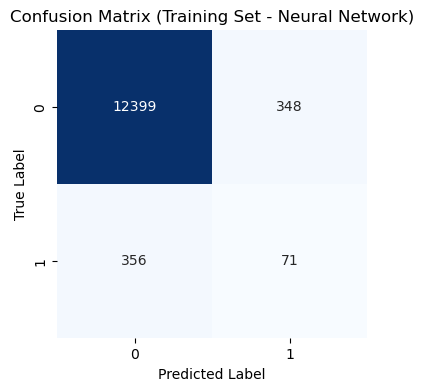

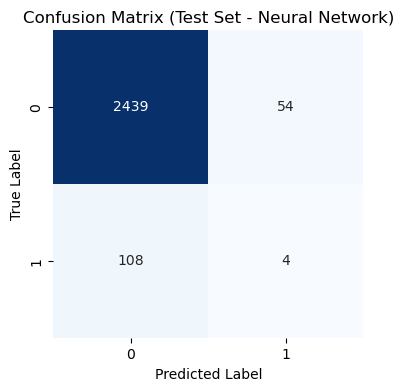

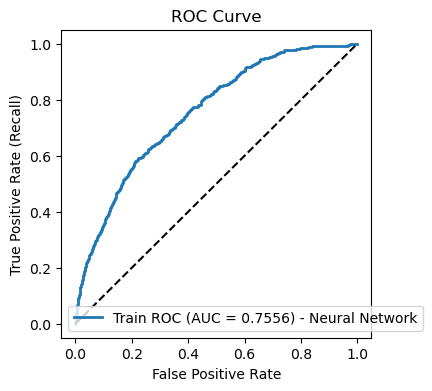

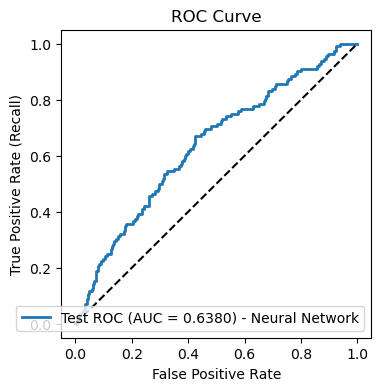

In [28]:
train_data = df_mf[df_mf['year'].isin([2016, 2017, 2018, 2019, 2020])]
test_data = df_mf[df_mf['year'] == 2021]

X_train = train_data[factors]
y_train = train_data['targeted']

X_test = test_data[factors]
y_test = test_data['targeted']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

y_pred_train_nn = model.predict(X_train_scaled)
y_pred_test_nn = model.predict(X_test_scaled)

cm_train_nn = confusion_matrix(y_train, y_pred_train_nn > 0.1)
cm_test_nn = confusion_matrix(y_test, y_pred_test_nn > 0.1)

plot_confusion_matrix(cm_train_nn, 'Confusion Matrix (Training Set - Neural Network)')
plot_confusion_matrix(cm_test_nn, 'Confusion Matrix (Test Set - Neural Network)')

auc_train_nn = roc_auc_score(y_train, y_pred_train_nn)
auc_test_nn = roc_auc_score(y_test, y_pred_test_nn)

plot_roc_curve(y_train, y_pred_train_nn, label=f"Train ROC (AUC = {auc_train_nn:.4f}) - Neural Network")
plot_roc_curve(y_test, y_pred_test_nn, label=f"Test ROC (AUC = {auc_test_nn:.4f}) - Neural Network")
plt.legend(loc="lower right")
plt.show()


In [29]:
xgboost_model = xgb.XGBClassifier()
xgboost_model.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=14)

In [30]:
y_pred_train = cross_val_predict(xgboost_model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred_test = xgboost_model.predict_proba(X_test)[:, 1]

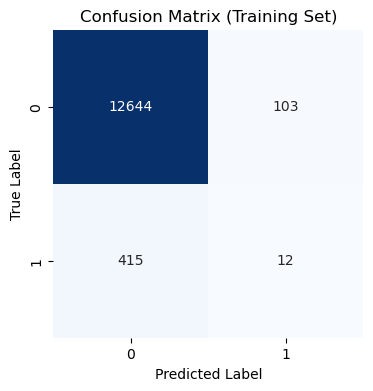

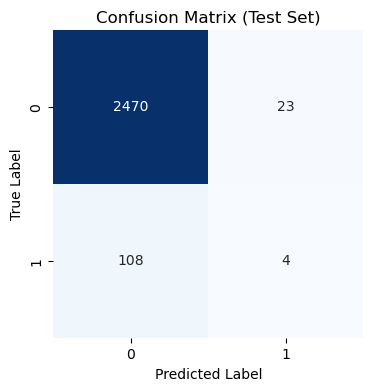

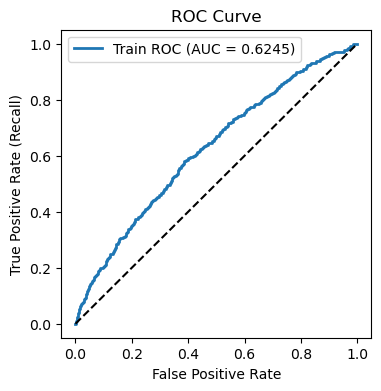

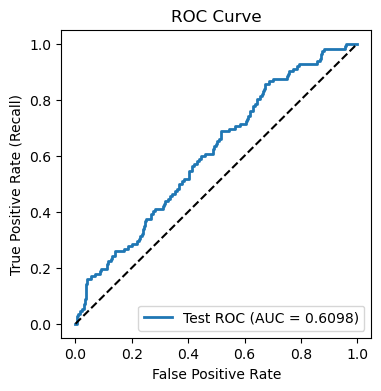

In [31]:
cm_train = confusion_matrix(y_train, y_pred_train > 0.1)
cm_test = confusion_matrix(y_test, y_pred_test > 0.1)

plot_confusion_matrix(cm_train, 'Confusion Matrix (Training Set)')
plot_confusion_matrix(cm_test, 'Confusion Matrix (Test Set)')

auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)

plot_roc_curve(y_train, y_pred_train, label=f"Train ROC (AUC = {auc_train:.4f})")
plot_roc_curve(y_test, y_pred_test, label=f"Test ROC (AUC = {auc_test:.4f})")
plt.legend(loc="lower right")
plt.show()


# 3. Conduct column creation

In [32]:
columns_to_process = [
    "capex",
    "net_capex",
    "short_term_wc",
    "long_term_wc",
    "modified_wc",
    "ebitda",
    "ebit",
    "net_income",
    "net_debt",
    "ev",
    "repurchase",
    "board_size",
    "net_repurchase",
    "total_compensation_to_executives",
    "total_compensation_to_board_members",
    "dividend_to_common",
    "dividend_to_preferred"
]

for col in columns_to_process:
    
    # 1. _percentile
    percentile_col = col + '_percentile'
    df_mf[percentile_col] = df_mf.groupby('year')[col].transform(lambda x: x.rank(pct=True) * 100)
    df_mf[percentile_col].fillna(50, inplace=True)
    
    # 2. _10bins_percentile
    df_mf['market_cap_bins'] = df_mf.groupby('year')['market_cap'].transform(lambda x: pd.cut(x, bins=10))
    percentile_10bins_col = col + '_10bins_percentile'
    df_mf[percentile_10bins_col] = df_mf.groupby(['year', 'market_cap_bins'])[col].transform(lambda x: x.rank(pct=True) * 100)
    df_mf[percentile_10bins_col].fillna(50, inplace=True)
    df_mf.drop('market_cap_bins', axis=1, inplace=True)

    # 3. _10bins_normalized
    df_mf['market_cap_bins'] = df_mf.groupby('year')['market_cap'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
    normalized_col = col + '_10bins_normalized'
    df_mf[normalized_col] = df_mf.groupby(['year', 'market_cap_bins'])[col].transform(lambda x: (x - x.mean()) / x.std())
    df_mf[normalized_col].fillna(0, inplace=True)
    df_mf.drop('market_cap_bins', axis=1, inplace=True)
    
    # 4. _div_market_cap
    div_market_cap_col = col + '_div_market_cap'
    df_mf[div_market_cap_col] = df_mf[col] / df_mf['market_cap']
    
    # 5. _div_log_market_cap
    df_mf['log_market_cap'] = np.log(df_mf['market_cap'])
    div_log_market_cap_col = col + '_div_log_market_cap'
    df_mf[div_log_market_cap_col] = df_mf[col] / df_mf['log_market_cap']
    
    for new_col in [div_market_cap_col, div_log_market_cap_col]:
        median_values = df_mf.groupby('year')[new_col].transform('median')
        df_mf[new_col].fillna(median_values, inplace=True)
    df_mf.drop('log_market_cap', axis=1, inplace=True)

In [33]:
columns_to_process = [
    "ebitda_margin",
    "operating_margin",
    "sales_to_total_assets",
    "roe",
    "normalized_roe",
    "operating_roe",
    "operating_roic",
    "eps_adjusted_diluted",
    "ev_to_sales",
    "tobin_q_ratio",
    "pb_ratio",
    "pe_ratio",
    "fcf_to_equity",
    "sales_growth_rate",
    "dividend_per_share",
    "dividend_payout_ratio",
    "asset_to_equity",
    "cash_conversion_cycle",
    "ev_ebitda",
    "ev_ebit",
]
def compute_percentile(group):
    if len(group) < 10:
        return pd.Series([None] * len(group), index=group.index, dtype=float)
    return group.rank(pct=True) * 100

def normalize(group):
    if len(group) < 10:
        return pd.Series([None] * len(group), index=group.index, dtype=float)
    return (group - group.mean()) / group.std()

for col in columns_to_process:
    percentile_col = col + '_industry_peers_percentile'
    df_mf[percentile_col] = df_mf.groupby(['year', 'bic_level_3'])[col].transform(compute_percentile)
    mask = df_mf[percentile_col].isna()
    df_mf.loc[mask, percentile_col] = df_mf[mask].groupby(['year', 'bic_level_2'])[col].transform(compute_percentile)
    df_mf[percentile_col].fillna(50, inplace=True)
    df_mf[percentile_col] = df_mf[percentile_col].astype(float)
    normalized_col = col + '_industry_peers_normalized'
    df_mf[normalized_col] = df_mf.groupby(['year', 'bic_level_3'])[col].transform(normalize)
    mask = df_mf[normalized_col].isna()
    df_mf.loc[mask, normalized_col] = df_mf[mask].groupby(['year', 'bic_level_2'])[col].transform(normalize)
    df_mf[normalized_col].fillna(0, inplace=True)
    df_mf[normalized_col] = df_mf[normalized_col].astype(float)
    df_mf[col].fillna(df_mf.groupby('year')[col].transform('median'), inplace=True)


In [34]:
new_factors = []
for col in non_ratio_variables:
    new_factors.extend([
        col,
        f'{col}_percentile',
        f'{col}_10bins_percentile',
        f'{col}_10bins_normalized',
        f'{col}_div_market_cap',
        f'{col}_div_log_market_cap'
    ])

for col in ratio_variables:
    new_factors.extend([
        col,
        f'{col}_industry_peers_percentile',
        f'{col}_industry_peers_normalized'
    ])

new_factors = new_factors + binary + technical_variables

# 5. Re-run models

Epoch 1/10
330/330 [==============================] - 0s 1ms/step - loss: 0.2146 - accuracy: 0.9588 - val_loss: 0.1102 - val_accuracy: 0.9780
Epoch 2/10
330/330 [==============================] - 0s 651us/step - loss: 0.1744 - accuracy: 0.9641 - val_loss: 0.1130 - val_accuracy: 0.9780
Epoch 3/10
330/330 [==============================] - 0s 650us/step - loss: 0.1575 - accuracy: 0.9644 - val_loss: 0.1060 - val_accuracy: 0.9780
Epoch 4/10
330/330 [==============================] - 0s 639us/step - loss: 0.1557 - accuracy: 0.9644 - val_loss: 0.1126 - val_accuracy: 0.9780
Epoch 5/10
330/330 [==============================] - 0s 647us/step - loss: 0.1526 - accuracy: 0.9645 - val_loss: 0.1078 - val_accuracy: 0.9780
Epoch 6/10
330/330 [==============================] - 0s 648us/step - loss: 0.1496 - accuracy: 0.9652 - val_loss: 0.1055 - val_accuracy: 0.9780
Epoch 7/10
330/330 [==============================] - 0s 646us/step - loss: 0.1412 - accuracy: 0.9648 - val_loss: 0.1123 - val_accuracy: 0

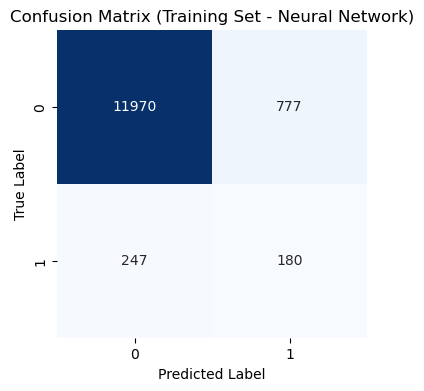

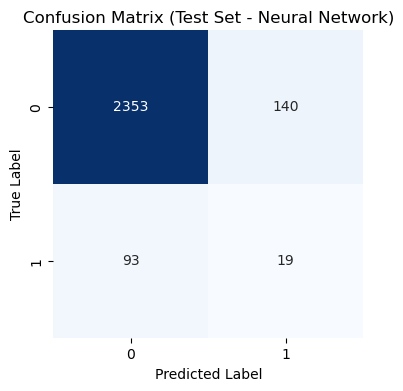

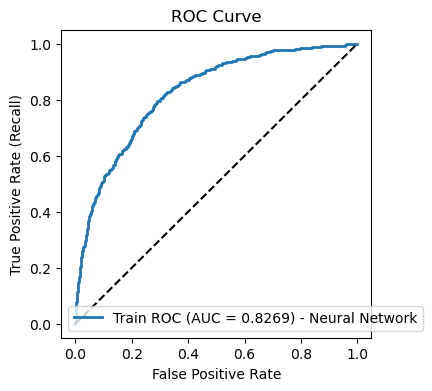

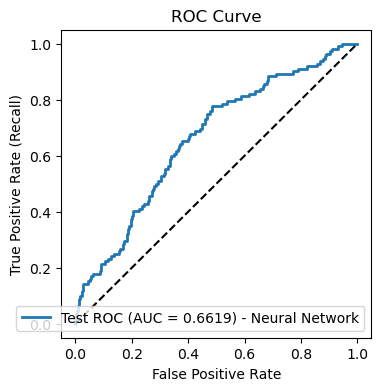

In [35]:
train_data = df_mf[df_mf['year'].isin([2016, 2017, 2018, 2019, 2020])]
test_data = df_mf[df_mf['year'] == 2021]

X_train = train_data[new_factors]
y_train = train_data['targeted']

X_test = test_data[new_factors]
y_test = test_data['targeted']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

y_pred_train_nn = model.predict(X_train_scaled)
y_pred_test_nn = model.predict(X_test_scaled)

cm_train_nn = confusion_matrix(y_train, y_pred_train_nn > 0.1)
cm_test_nn = confusion_matrix(y_test, y_pred_test_nn > 0.1)

plot_confusion_matrix(cm_train_nn, 'Confusion Matrix (Training Set - Neural Network)')
plot_confusion_matrix(cm_test_nn, 'Confusion Matrix (Test Set - Neural Network)')

auc_train_nn = roc_auc_score(y_train, y_pred_train_nn)
auc_test_nn = roc_auc_score(y_test, y_pred_test_nn)

plot_roc_curve(y_train, y_pred_train_nn, label=f"Train ROC (AUC = {auc_train_nn:.4f}) - Neural Network")
plot_roc_curve(y_test, y_pred_test_nn, label=f"Test ROC (AUC = {auc_test_nn:.4f}) - Neural Network")
plt.legend(loc="lower right")
plt.show()


In [36]:
xgboost_model = xgb.XGBClassifier()
xgboost_model.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=14)

In [37]:
y_pred_train = cross_val_predict(xgboost_model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred_test = xgboost_model.predict_proba(X_test)[:, 1]

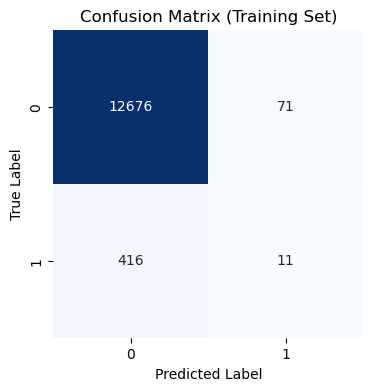

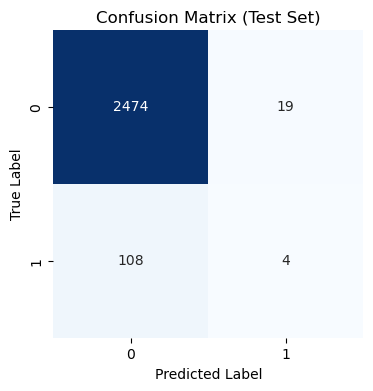

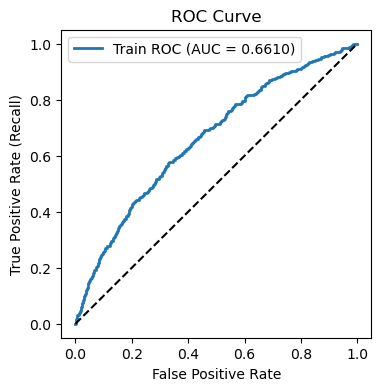

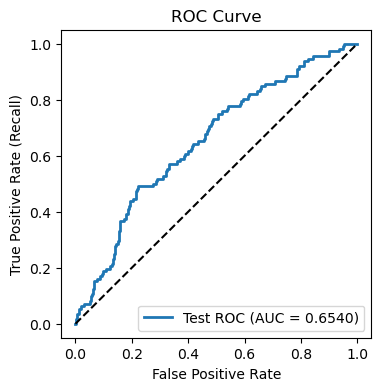

In [38]:
cm_train = confusion_matrix(y_train, y_pred_train > 0.1)
cm_test = confusion_matrix(y_test, y_pred_test > 0.1)

plot_confusion_matrix(cm_train, 'Confusion Matrix (Training Set)')
plot_confusion_matrix(cm_test, 'Confusion Matrix (Test Set)')

auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)

plot_roc_curve(y_train, y_pred_train, label=f"Train ROC (AUC = {auc_train:.4f})")
plot_roc_curve(y_test, y_pred_test, label=f"Test ROC (AUC = {auc_test:.4f})")
plt.legend(loc="lower right")
plt.show()

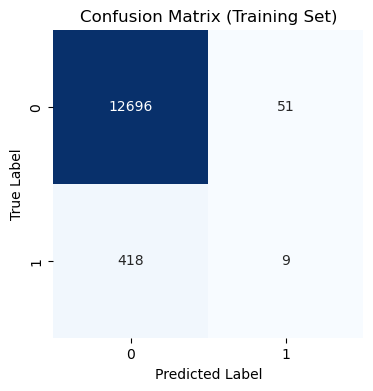

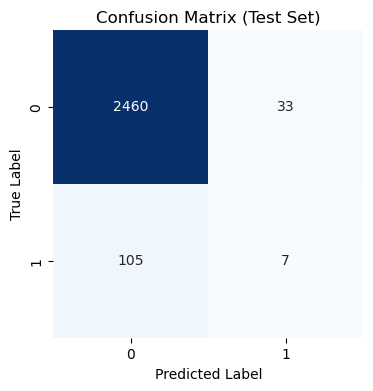

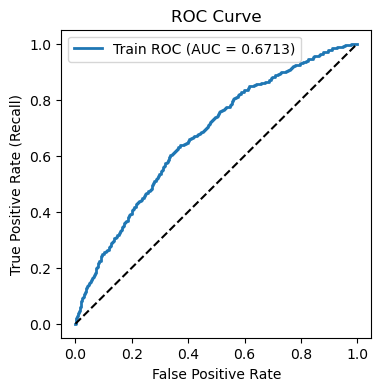

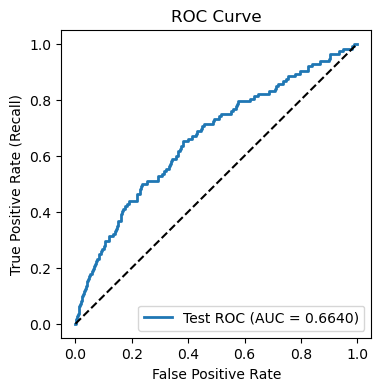

In [39]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=14)

y_pred_train = cross_val_predict(lgb_model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred_test = lgb_model.predict_proba(X_test)[:, 1]

cm_train = confusion_matrix(y_train, y_pred_train > 0.1)
cm_test = confusion_matrix(y_test, y_pred_test > 0.1)

# Assuming you have a function to plot confusion matrix
plot_confusion_matrix(cm_train, 'Confusion Matrix (Training Set)')
plot_confusion_matrix(cm_test, 'Confusion Matrix (Test Set)')

auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)

plot_roc_curve(y_train, y_pred_train, label=f"Train ROC (AUC = {auc_train:.4f})")
plot_roc_curve(y_test, y_pred_test, label=f"Test ROC (AUC = {auc_test:.4f})")
plt.legend(loc="lower right")
plt.show()


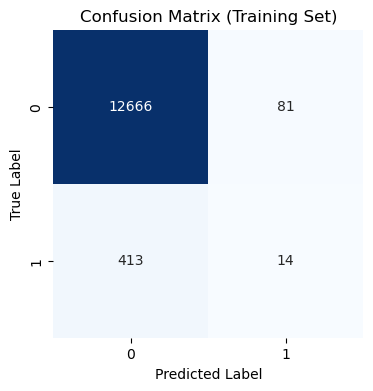

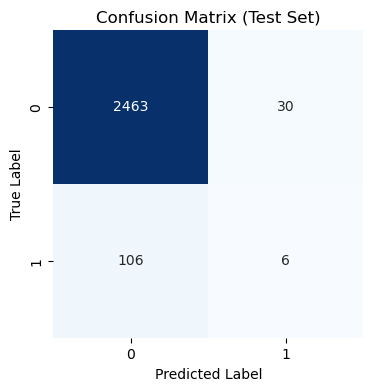

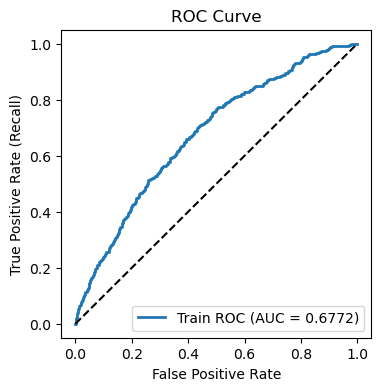

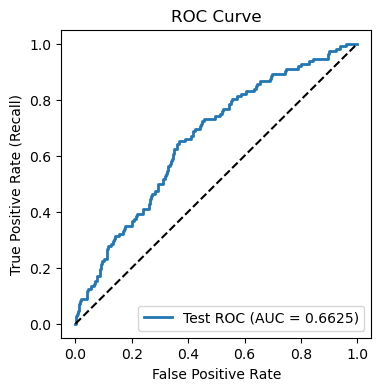

In [41]:
import catboost as cb

# Initialize and train
cb_model = cb.CatBoostClassifier(silent=True)  # silent=True to suppress verbose output
cb_model.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=14)

y_pred_train = cross_val_predict(cb_model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred_test = cb_model.predict_proba(X_test)[:, 1]

cm_train = confusion_matrix(y_train, y_pred_train > 0.1)
cm_test = confusion_matrix(y_test, y_pred_test > 0.1)

# Assuming you have a function to plot confusion matrix
plot_confusion_matrix(cm_train, 'Confusion Matrix (Training Set)')
plot_confusion_matrix(cm_test, 'Confusion Matrix (Test Set)')

auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)

plot_roc_curve(y_train, y_pred_train, label=f"Train ROC (AUC = {auc_train:.4f})")
plot_roc_curve(y_test, y_pred_test, label=f"Test ROC (AUC = {auc_test:.4f})")
plt.legend(loc="lower right")
plt.show()
